In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
large = screen_funds('Equities', 'Domestic', 'Large-Cap')
mid = screen_funds('Equities', 'Domestic', 'Mid-Cap')
small = screen_funds('Equities', 'Domestic', 'Small-Cap')
print(len(large), len(mid), len(small))
quote = Quote(large + mid + small, 60, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

80 20 21
from 2019-05-15 to 2019-07-12 - 121


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

119


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
MTUM,36,0.200965,0.378838,0.509529,8.922659,2.638699
PDP,36,0.197476,0.423155,0.447921,8.882259,3.212556
USMV,36,0.171891,0.304508,0.538423,7.566530,1.936934
JKE,36,0.169185,0.416931,0.386752,7.308733,5.543676
IWP,36,0.164837,0.418668,0.374762,7.186875,4.264995
SCHG,36,0.156653,0.409565,0.363109,6.981377,5.408728
VIG,36,0.155541,0.351816,0.419550,7.115559,3.083112
IWY,36,0.152344,0.436171,0.331080,6.554728,5.937531
VONG,36,0.152152,0.427016,0.337729,6.601061,5.690608


evicted TILT 0.678 0.645
evicted USA 0.838 0.738
evicted XSLV 0.754 0.754
retry backlogs ['SDOG', 'RVT', 'FEX', 'PRFZ', 'FPX', 'SCHV', 'PWV', 'SDY', 'DLN', 'FTA', 'SPHD', 'IWM', 'VOT', 'FV', 'VYM', 'ONEQ', 'VUG', 'MGK', 'RSP', 'VONG', 'VONE', 'VO', 'FTCS', 'SLY', 'SLYV', 'IJR', 'DVY', 'IJT', 'IWP', 'GSLC', 'SPYG', 'XMLV', 'QUAL', 'IJJ', 'IWR', 'IJH', 'VONV', 'VOE', 'IYY', 'MDYV', 'SPMD', 'VBR', 'JHMM', 'SCHX', 'VXF', 'VV', 'QDF', 'VTI', 'FVD', 'SUSA', 'SPLG', 'SPY', 'DGRO', 'VOO', 'IWS', 'SPLV', 'VB', 'MGC', 'IWV', 'DSI', 'OEF', 'IVE', 'LRGF', 'QQQ', 'VTV', 'SPSM', 'IVV', 'PKW', 'EZM', 'PRF', 'IWD', 'IWF', 'FNDX', 'IUSV', 'SCHA', 'SCHB', 'HDV', 'SCHM', 'IWB', 'IUSG', 'VIOO', 'MDYG', 'FNDA', 'VBK', 'SPTM', 'ITOT', 'IWY', 'IVW', 'MDY', 'DGRW', 'VIG', 'SPYD', 'JKE', 'DON', 'SPYV', 'IJK', 'PDP', 'SCHG', 'IJS', 'RPG', 'SPHQ', 'MOAT', 'MTUM', 'VOOG', 'NOBL', 'SLYG', 'IWO', 'RDIV', 'SCHD', 'MGV', 'VTWO', 'DIA', 'VLUE', 'FDL', 'ADX'] at 0.905/-0.51 - 0.538
evicted FDL 0.884 0.592
evicted VIOO 

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
USMV,36.0,0.171891,0.304508,-0.343861,0.008378,0.177576,0.326643,0.844584,0.538423,7.56653,1.936934
Portfolio,36.0,0.171891,0.304508,-0.343861,0.008378,0.177576,0.326643,0.844584,0.538423,7.56653,1.936934


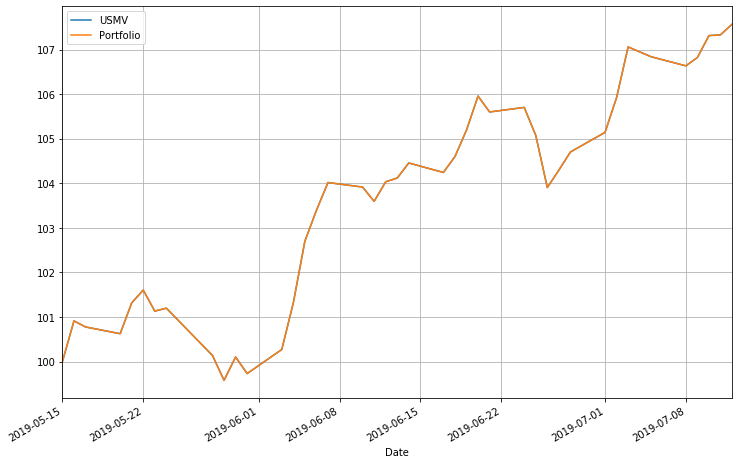

In [4]:
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(_lambda=1)
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(_lambda=1))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)